In [117]:
import imp
from operator import imod
import click
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from os import mkdir, getcwd, path
import nilearn
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.image import mean_img, smooth_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_contrast_matrix
import nibabel as nib
from nilearn import plotting
import argparse
from nilearn.maskers import NiftiSpheresMasker

In [9]:
outfile = '/Users/xinyi/Documents/GitHub/fMRI-PhysioNoise'
regressors = '/Users/xinyi/Documents/GitHub/fMRI-PhysioNoise/test/0.0/physio/regressors.csv'
t_scan = '/Users/xinyi/Documents/GitHub/fMRI-PhysioNoise/test/0.0/physio/mri_pulse.csv'

with open(t_scan) as file_name:
    frame_times = np.loadtxt(file_name)

# write directory
if not os.path.exists(outfile):
    mkdir(outfile)

outDir = outfile + "/analysis"
if not os.path.exists(outDir):
    mkdir(outDir)

print('Computation will be performed in directory: %s' %outDir)

# Define the calculated regressors
reg = pd.read_csv(regressors)
add_reg_names = []

index = len(reg.columns)
for i in range(index):
    add_reg_names.append('L%s'%i)

# input the time of scanning
with open(t_scan) as file_name:
    frame_times = np.loadtxt(file_name)
frame_times = frame_times[1:]


Computation will be performed in directory: /Users/xinyi/Documents/GitHub/fMRI-PhysioNoise/analysis


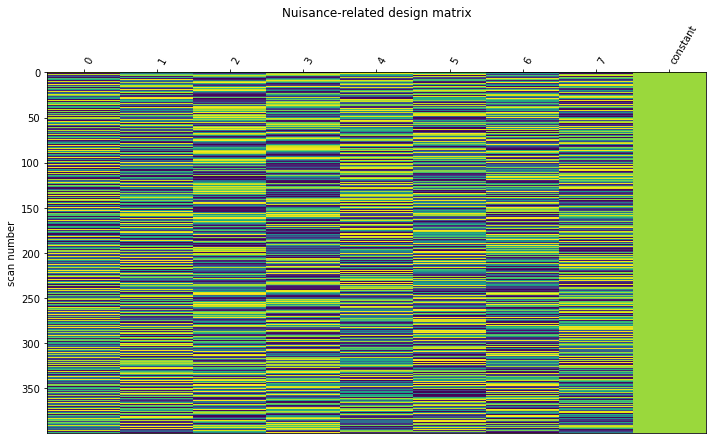

In [11]:

# Define the empty tasks conditions
conditions = []
duration = []
onsets = []

events = pd.DataFrame({'trial_type': conditions, 'onset': onsets,
                    'duration': duration})


# Design the 1st level analysis
hrf_model = 'glover'
X1 = make_first_level_design_matrix(
    frame_times, events, drift_model=None,
    add_regs=reg, add_reg_names=add_reg_names, hrf_model=hrf_model)


fig, (ax1) = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
plot_design_matrix(X1, ax=ax1)
ax1.set_title('Nuisance-related design matrix', fontsize=12)
fig.savefig(outDir + '/design_matrix.png')


range(1, 8)

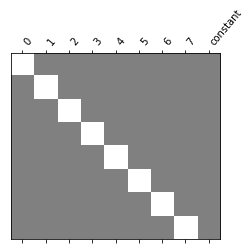

In [75]:
infile = '/Users/xinyi/Documents/GitHub/fMRI-PhysioNoise/test/0.0/prep/motion/_realign0/sub01_mcf.nii.gz'

# Build the 1st level model
fmri_glm = FirstLevelModel(
                        minimize_memory=False)
# Get the number of components and constant(residual)
n_columns = X1.shape[1]
mean = mean_img(infile)

# Build contrasts for each noise component
contrasts = np.zeros([index,index+1])
for i in range(index):
    contrasts[i,i] = 1

ax2 = plot_contrast_matrix(contrasts, design_matrix=X1)
ax2.figure.savefig(outDir + '/contrasts.png')

# Fit with GLM model
fmri_glm = fmri_glm.fit(infile, design_matrices=X1)

# Save the nii image of statistical value of each noise component
for i in range(index):
    z_img = fmri_glm.compute_contrast(contrasts[i], 
                        output_type='z_score')
    nib.save(z_img, os.path.join(outDir,"zstat_%s.nii.gz"%i))
    # Plot the contrasts
    plotting.plot_stat_map(
        z_img,
        bg_img=mean, threshold=3, 
        title="zsta_component_%s"%i,
        output_file = os.path.join(outDir,"zstat_cont_%s.png"%i))
# Save the residual data for the further use


In [50]:
str = '/Users/xinyi/Desktop/project/subject/struct.nii'
mean_str = mean_img(str)


In [51]:
mean_str.shape

(208, 256, 170)

In [56]:
infile = smooth_img(infile,2)

In [59]:
infile.shape

(94, 94, 56, 400)

TypeError: Cannot slice image objects; consider using `img.slicer[slice]` to generate a sliced image (see documentation for caveats) or slicing image array data with `img.dataobj[slice]` or `img.get_fdata()[slice]`

In [61]:
from nilearn.decomposition import DictLearning

# Initialize DictLearning object
dict_learn = DictLearning(n_components=8, target_affine= mean_str,
                          memory="nilearn_cache", memory_level=2,
                          random_state=0)
# Fit to the data
# Resting state networks/maps in attribute `components_img_`
components_img = dict_learn.components_img_


TypeError: Cannot slice image objects; consider using `img.slicer[slice]` to generate a sliced image (see documentation for caveats) or slicing image array data with `img.dataobj[slice]` or `img.get_fdata()[slice]`

/Users/xinyi/.local/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/Users/xinyi/.local/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),
/Users/xinyi/.local/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/Users/xinyi/.local/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),
/Users/xinyi/.local/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),
/Users/xinyi/.local/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: Us

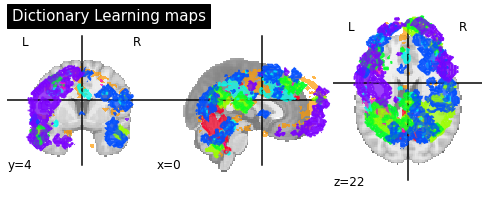

In [40]:
plotting.plot_prob_atlas(components_img, view_type='filled_contours',
                         title='Dictionary Learning maps')

## New method: Use clusters

In [136]:
outfile = '/Users/xinyi/Documents/GitHub/fMRI-PhysioNoise'
regressors = '/Users/xinyi/Documents/GitHub/fMRI-PhysioNoise/test/0.0/physio/regressors.csv'
t_scan = '/Users/xinyi/Documents/GitHub/fMRI-PhysioNoise/test/0.0/physio/mri_pulse.csv'

In [160]:
from nilearn._utils.niimg_conversions import check_niimg_4d
fmri_img = '/Users/xinyi/Documents/GitHub/fMRI-PhysioNoise/test/0.0/prep/motion/_realign0/sub01_mcf.nii'
fmri_img = check_niimg_4d(fmri_img)

In [166]:
from nilearn import masking

back_mask = masking.compute_background_mask(fmri_img)
img_ = masking.apply_mask(fmri_img,back_mask)

In [165]:
fmri_img.shape

(94, 94, 56, 400)

In [168]:
## prep
from nilearn import image


# load fMRI data
img = '/Users/xinyi/Documents/GitHub/fMRI-PhysioNoise/test/0.0/prep/motion/_realign0/sub01_mcf.nii'

# Make an average
mean_img = image.mean_img(img)
mask = masking.compute_epi_mask(mean_img)

# # Clean and smooth data
# fmri_img = image.clean_img(fmri_img, standardize=False)
# fmri_img = smooth_img(fmri_img, 5.)

# load events
# Define the empty tasks conditions
conditions = []
duration = []
onsets = []

events = pd.DataFrame({'trial_type': conditions, 'onset': onsets,
                    'duration': duration})


# Define the calculated regressors
reg = pd.read_csv(regressors)
add_reg_names = []

index = len(reg.columns)
for i in range(index):
    add_reg_names.append('L%s'%i)

# input the time of scanning
with open(t_scan) as file_name:
    frame_times = np.loadtxt(file_name)
frame_times = frame_times[1:]

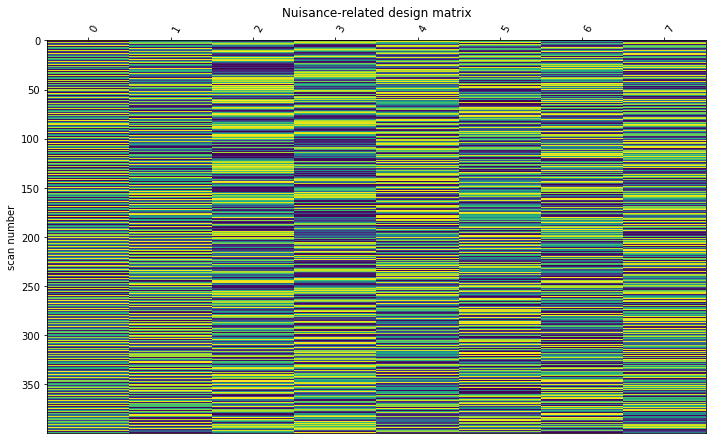

In [169]:

# Design the 1st level analysis
X1 = make_first_level_design_matrix(frame_times, events, 
                                    drift_model=None,
                                    add_regs=reg, 
                                    add_reg_names=add_reg_names, 
                                    hrf_model=None)

X1.pop(X1.columns[-1])
fig, (ax1) = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
plot_design_matrix(X1, ax=ax1)
ax1.set_title('Nuisance-related design matrix', fontsize=12)
fig.savefig(outDir + '/design_matrix.png')


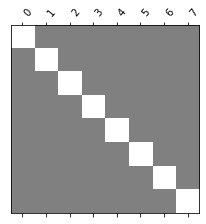

In [170]:
# infile = '/Users/xinyi/Desktop/project/subject/sub01.nii'

# Build the 1st level model
fmri_glm = FirstLevelModel(t_r=1.7, minimize_memory=False)
# Get the number of components and constant(residual)
n_columns = X1.shape[1]
# mean = mean_img(infile)

# Build contrasts for each noise component
contrasts = np.zeros([index,index])
for i in range(index):
    contrasts[i,i] = 1

ax2 = plot_contrast_matrix(contrasts, design_matrix=X1)
ax2.figure.savefig(outDir + '/contrasts.png')

# Fit with GLM model
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=X1)

# Save the nii image of statistical value of each noise component
for i in range(index):
    z_img = fmri_glm.compute_contrast(contrasts[i], 
                        output_type='z_score')
    nib.save(z_img, os.path.join(outDir,"zstat_%s.nii.gz"%i))
    # Plot the contrasts
    plotting.plot_stat_map(
        z_img,
        bg_img=mean_img, threshold=3, 
        title="zsta_component_%s"%i,
        output_file = os.path.join(outDir,"zstat_cont_%s.png"%i))
# Save the residual data for the further use


In [171]:
nib.save(fmri_glm.residuals[0],os.path.join(outDir,"residual.nii.gz"))

/Users/xinyi/.local/lib/python3.8/site-packages/nilearn/glm/regression.py:42: FutureWarning: 'resid' has been deprecated in version 0.7.0 and will be removed in version 0.9.0. Please use 'residuals' instead.
  warnings.warn(category=FutureWarning,


In [172]:
## Extract clusters

from nilearn.reporting import get_clusters_table
from nilearn.maskers import NiftiSpheresMasker

table = get_clusters_table(z_img, stat_threshold=3,
                           cluster_threshold=None).set_index('Cluster ID', drop=True)
table.head()



,X,Y,Z,Peak Stat,Cluster Size (mm3)
Cluster ID,,,,,
1,5.487200,-76.124082,-7.091395,8.841000,50
2,3.464235,-72.611489,-14.568917,8.528547,133
3,1.355932,-73.859286,-8.723399,8.321144,16
4,7.711531,-76.089441,-17.259737,6.804117,33
5,-2.887593,20.755796,59.211344,6.578472,200


In [173]:
# get the 8 largest clusters' max x, y, and z coordinates
coords = table.loc[range(1,6), ['X', 'Y', 'Z']].values

# extract time series from each coordinate
masker = NiftiSpheresMasker(coords)
real_timeseries = masker.fit_transform(infile)


In [176]:
coords

array([[  5.48719954, -76.12408232,  -7.09139458],
       [  3.46423505, -72.61148888, -14.56891698],
       [  1.35593171, -73.85928593,  -8.72339915],
       [  7.7115308 , -76.0894412 , -17.25973692],
       [ -2.88759293,  20.7557961 ,  59.21134437]])

In [174]:
predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0])
corrected_timeseries = masker.fit_transform(fmri_glm.residuals[0])

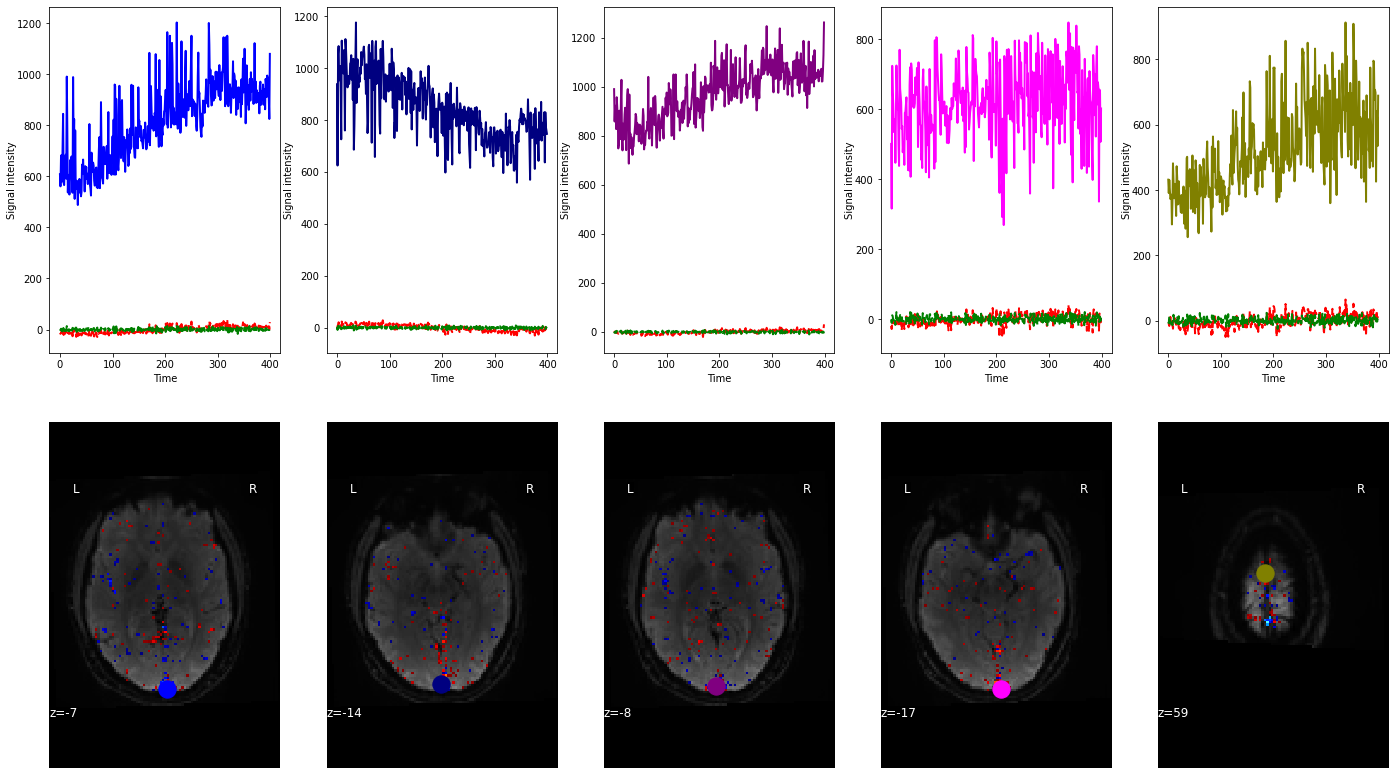

In [175]:
import matplotlib.pyplot as plt

# colors for each of the clusters
colors = ['blue', 'navy', 'purple', 'magenta', 'olive']
# plot the time series and corresponding locations
fig1, axs1 = plt.subplots(2, 5)
for i in range(0, 5):
    # plotting time series
    # axs1[0, i].set_title('Cluster peak {}\n'.format(coords[i]))
    axs1[0, i].plot(real_timeseries[:, i], c=colors[i], lw=2)
    axs1[0, i].plot(corrected_timeseries[:, i], c='r', ls='--', lw=2)
    axs1[0, i].plot(predicted_timeseries[:, i], c='g', ls='--', lw=2)
    axs1[0, i].set_xlabel('Time')
    axs1[0, i].set_ylabel('Signal intensity', labelpad=0)
    # plotting image below the time series
    roi_img = plotting.plot_stat_map(
        z_img, cut_coords=[coords[i][2]], threshold=2, figure=fig1,
        axes=axs1[1, i], display_mode='z', colorbar=False, bg_img=mean)
    roi_img.add_markers([coords[i]], colors[i], 300)
fig1.set_size_inches(24, 14)